In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


THE QUESTIONS I'LL BE SOLVING HERE.

1-What is the proportion of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department ?

2-How many electric vehicles are manufactured for each type of vehicle over the years ?

3-What is the propensity of vehicles to meet the eligibility criteria for Clean Alternative Fuel Vehicle incentives or benefits, for each type of vehicle ?

4-What manufacturers produce the most electric vehicles ?

5-Which type of vehicles have the most electric range?

**IMPORT AND CLEAN UP DATA**

In [14]:
# Importing librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Path to the file in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Electric_Vehicle_Population_Data.csv'

# Load the data
dataset = pd.read_csv(file_path)

# Show first lines to preview
dataset.head(2)

# Clean up some columns
dataset['Electric Vehicle Type'] = dataset['Electric Vehicle Type'].astype(str)
dataset['State'] = dataset['State'].astype(str)

# keep a copy of the original dataset for good practice
dataset_original = dataset.copy()

**HANDLING NAN (MISSING VALUES)**

<Figure size 300x200 with 0 Axes>

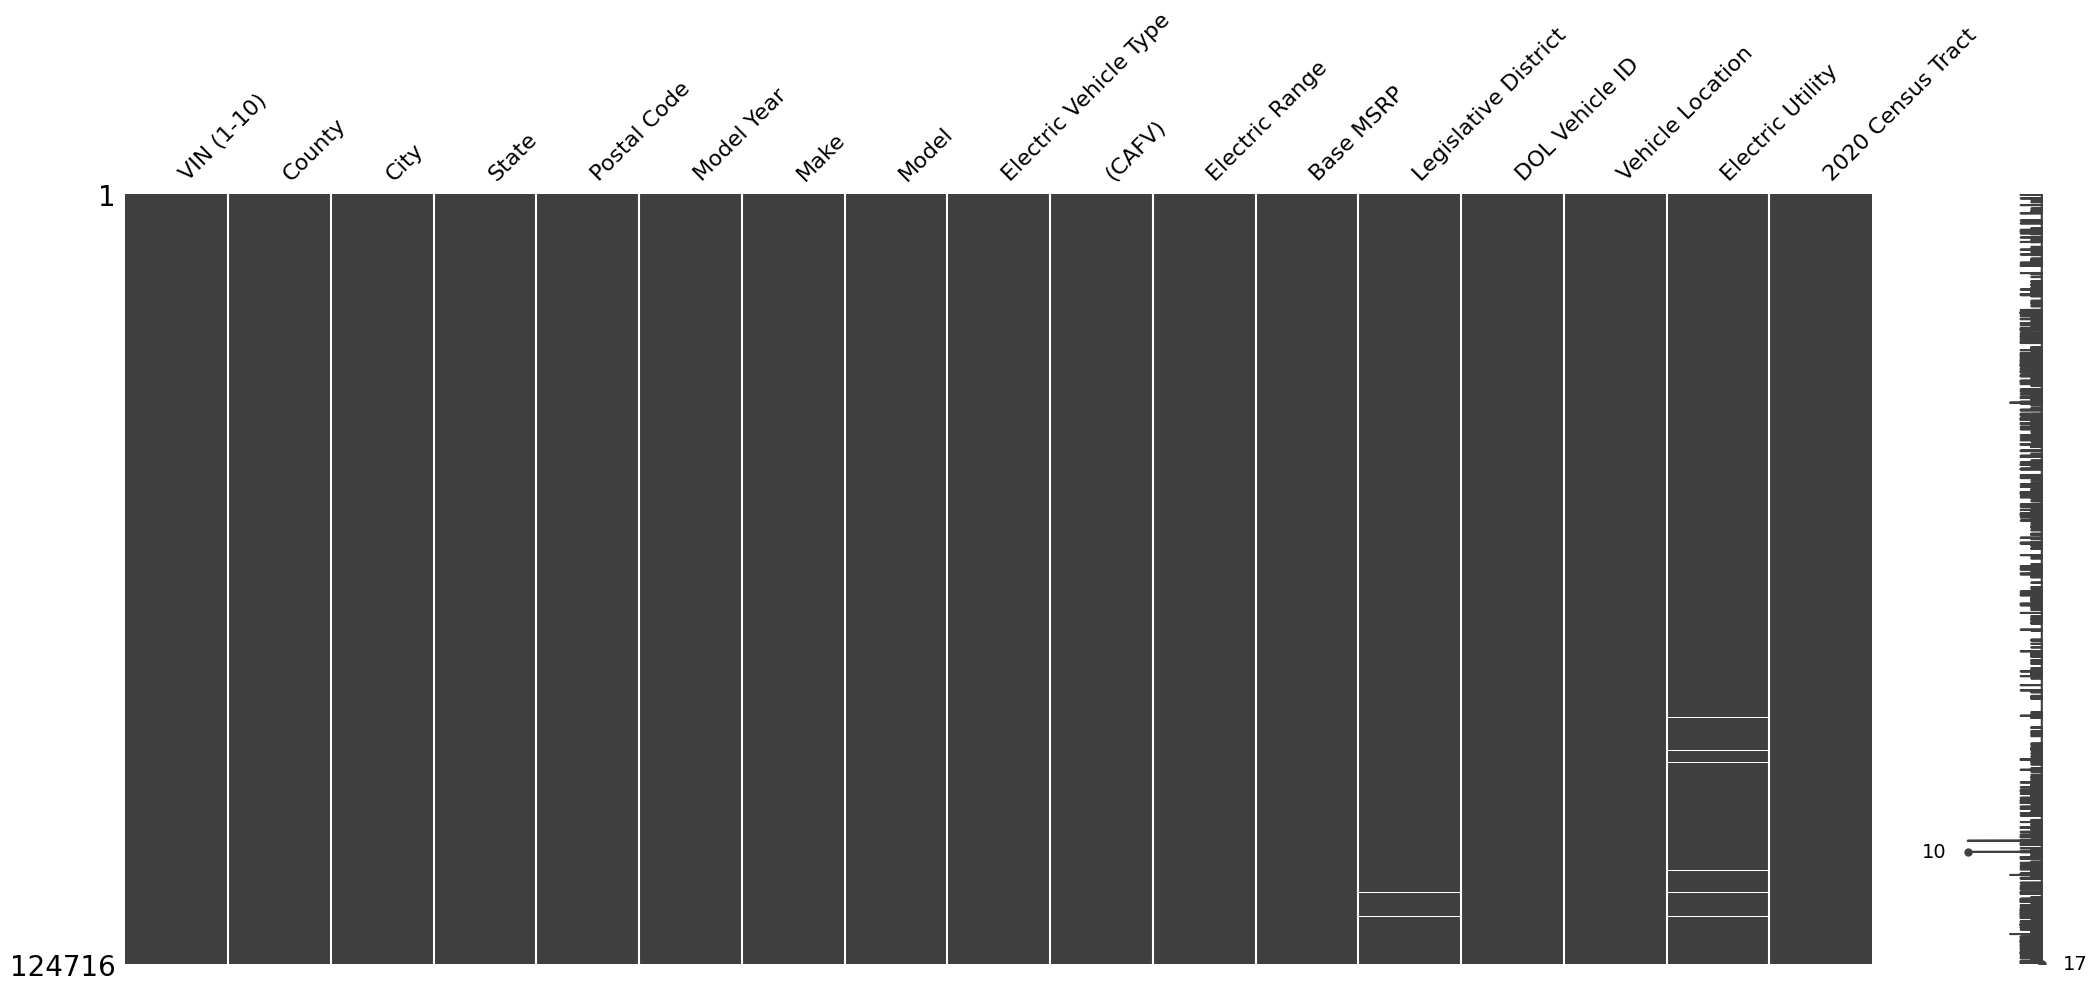

Total rows: 124716
Rows with at least one NaN: 678
Percentage of rows with NaN: 0.54%


In [15]:
# Step 1: Visualize missing values using missingno

plt.figure(figsize=(3, 2))  # Reduced the figure size
dataset_CAFV_renamed = dataset.copy()
dataset_CAFV_renamed.rename(columns={'Clean Alternative Fuel Vehicle (CAFV) Eligibility': '(CAFV)'}, inplace=True)
msno.matrix(dataset_CAFV_renamed)  # Replace with msno.bar(dataset) or msno.heatmap(dataset) for other plots
plt.show()

# Step 2: Calculate the percentage of missing values
# Calculate the total percentage of rows with at least one missing value
total_rows = len(dataset)
rows_with_nan = dataset.isnull().any(axis=1).sum()
percentage_rows_with_nan = (rows_with_nan / total_rows) * 100

# Print the result
print(f"Total rows: {total_rows}")
print(f"Rows with at least one NaN: {rows_with_nan}")
print(f"Percentage of rows with NaN: {percentage_rows_with_nan:.2f}%")

# So we can easily drop these nan values of the dataset
dataset = dataset.dropna()


1-What is the proportion of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department ?

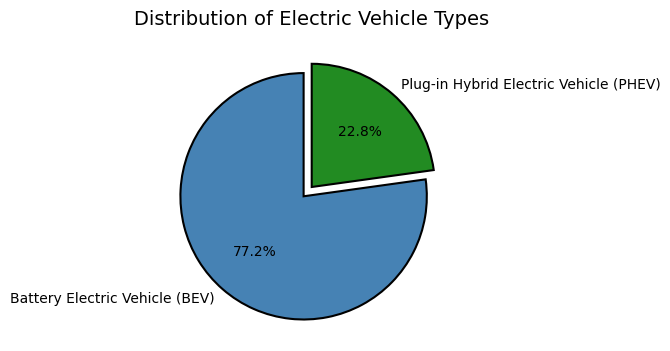

In [16]:
# Calculate the counts of each vehicle type
car_type = dataset['Electric Vehicle Type'].value_counts()

# Plot the pie chart
plt.figure(figsize=(4, 4))  # Set the figure size
plt.pie(
    car_type.values,
    labels=car_type.index,
    autopct='%1.1f%%',  # Display percentages with one decimal place
    startangle=90,      # Rotate the start angle for better visual alignment
    colors=['steelblue', 'forestgreen'],  # Darker colors
    explode=(0.1, 0),   # Slightly separate one slice for emphasis
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Add borders
)

# Add title
plt.title('Distribution of Electric Vehicle Types', fontsize=14)
plt.show()

2-How many electric vehicles are manufactured for each type of vehicle over the years ?

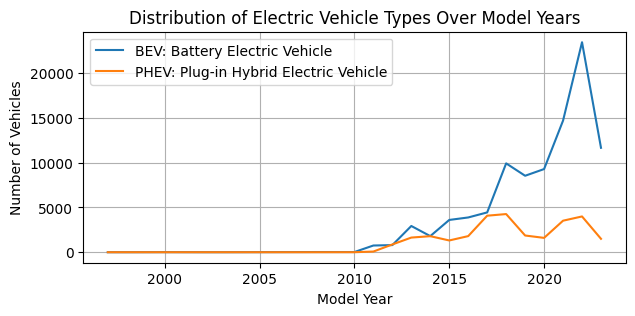

In [17]:
# Grouping data by 'Model Year' and 'Electric Vehicle Type'
distribution = dataset.groupby(['Model Year', 'Electric Vehicle Type'])['Electric Vehicle Type'].count().unstack(fill_value=0)

# Get the actual column names
# This technique i will use accounts for slight variations in the column names,
# such as additional spaces or unexpected prefixes, ensuring robustness.
# In the dataset, the names of the two types of vahicles are ('Battery Electric Vehicle' and 'Plug-in Hybrid Electric Vehicle'),
# which could fail if the dataset had unexpected column name variations.
bev_column = distribution.columns[distribution.columns.str.startswith('Battery')][0]
phev_column = distribution.columns[distribution.columns.str.startswith('Plug-in')][0]

# Plotting
plt.figure(figsize=(7, 3))
plt.plot(distribution.index, distribution[bev_column], label='BEV: Battery Electric Vehicle')
plt.plot(distribution.index, distribution[phev_column], label='PHEV: Plug-in Hybrid Electric Vehicle')

# Adding labels and title
plt.xlabel('Model Year')
plt.ylabel('Number of Vehicles')
plt.title('Distribution of Electric Vehicle Types Over Model Years')
plt.legend()
plt.grid()

# Show plot
plt.show()

3-What is the propensity of vehicles to meet the eligibility criteria for Clean Alternative Fuel Vehicle incentives or benefits, for each type of vehicle ?

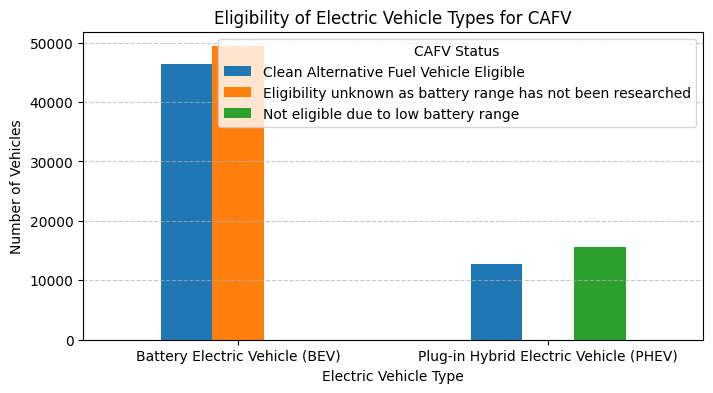

In [18]:
eligibility = dataset.groupby(['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']).size().unstack(fill_value=0)

# Plotting the graph
eligibility.plot(kind='bar', figsize=(8, 4))

# Adding labels and title
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Number of Vehicles')
plt.title('Eligibility of Electric Vehicle Types for CAFV')
plt.legend(title='CAFV Status')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the graph
plt.show()


In [19]:
eligibility

Clean Alternative Fuel Vehicle (CAFV) Eligibility,Clean Alternative Fuel Vehicle Eligible,Eligibility unknown as battery range has not been researched,Not eligible due to low battery range
Electric Vehicle Type,,,
Battery Electric Vehicle (BEV),46397,49346,10
Plug-in Hybrid Electric Vehicle (PHEV),12695,0,15590


-4 What manufacturers produce the most electric vehicles ?

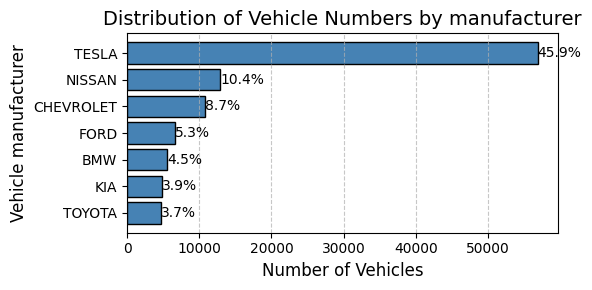

In [20]:
# Calculate counts for each manufacturer
manufacturer_counts = dataset['Make'].value_counts()

# Calculate percentages
total = manufacturer_counts.sum()
percentages = (manufacturer_counts / total * 100).round(1)

# Combine counts and percentages into a DataFrame for sorting
manufacturer_distribution = (
    manufacturer_counts.to_frame(name='Counts')
    .assign(Percentages=percentages)
    .sort_values(by='Counts', ascending=False)  # Sort by counts in descending order
)

#Restricting the dataset manufacture_counts to the top 10 manufacturers
manufacturer_distribution_plot = manufacturer_distribution.head(7)
# Plot horizontal bar chart
plt.figure(figsize=(6, 3))  # Adjust figure size
bars = plt.barh(manufacturer_distribution_plot.index, manufacturer_distribution_plot['Counts'], color='steelblue', edgecolor='black')

# Add percentages next to the bars
for bar, percentage in zip(bars, manufacturer_distribution_plot['Percentages']):
    plt.text(
        bar.get_width() + 5,  # Position percentage slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Center percentage vertically
        f'{percentage}%',
        va='center',
        fontsize=10
    )

# Add labels and title
plt.xlabel('Number of Vehicles', fontsize=12)
plt.ylabel('Vehicle manufacturer', fontsize=12)
plt.title('Distribution of Vehicle Numbers by manufacturer', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis so the highest percentage is at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add a grid for clarity
plt.tight_layout()  # Adjust layout to fit everything neatly

# Show plot
plt.show()


5-Which type of vehicles have the most electric range?

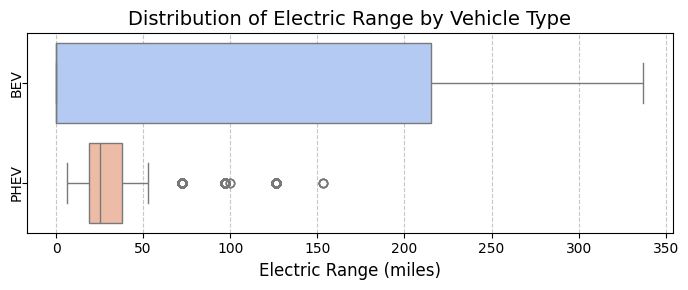

In [22]:
# Replace vehicle type names with abbreviations
range_vehicle = dataset.copy()
range_vehicle['Electric Vehicle Type'] = range_vehicle['Electric Vehicle Type'].replace({
    'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV',
    'Battery Electric Vehicle (BEV)': 'BEV'
})

# Create the horizontal boxplot
plt.figure(figsize=(7, 3))
sns.boxplot(data=range_vehicle, y='Electric Vehicle Type', x='Electric Range', hue='Electric Vehicle Type', palette='coolwarm', dodge=False)

# Adding labels and title
plt.ylabel('')  # Remove label for y-axis to make it less prominent
plt.xlabel('Electric Range (miles)', fontsize=12)
plt.title('Distribution of Electric Range by Vehicle Type', fontsize=14)

# Rotate and align y-axis labels
plt.yticks(rotation=90, ha='center', va='center', fontsize=10)

# Add grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()